In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import adjustText
import pygraphviz
from collections import Counter #,OrderedDict

In [2]:
def get_G(df_clust):
    
    df_clust["id"] = df_clust["TcRb"] +"_"+ df_clust["V"] +"_"+ [s.split(":")[1] for s in df_clust["Sample"]]
    
    esource,etarget = [],[]
    nID,nCDR3B,nTRBV,nSample,nPattern,nFscore = [],[],[],[],[],[]
    Iused = np.zeros(df_clust.shape[0],dtype=bool)
    dol = {}
    u_id = np.unique(df_clust["id"].values)
    for it,t in enumerate(u_id):
        I = df_clust["id"]==t
        ind = np.where(I)[0]
        cluster_ids = df_clust["index"][I].values
        Inbs = np.array([i in cluster_ids for i in df_clust["index"]])
        Inbs[I] = False # not self
        Inbs[Iused] = False # no double edges
        nbs = np.unique(df_clust['id'][Inbs])
        dol[it] = list(np.where([ui in nbs for ui in u_id])[0])

        tparts = t.split("_")
        nID.append(t)
        nCDR3B.append(tparts[0])
        nTRBV.append(tparts[1])
        nSample.append(tparts[2])
        nPattern.append(list(df_clust["pattern"][I])[np.argmax([len(p) for p in df_clust["pattern"][I]])])
        nFscore.append(min(df_clust["final_score"][I]))

        Iused[I] = True
        
    G = nx.from_dict_of_lists(dol)
    degs = nx.degree(G)
    vals = np.array([degs[k] for k in dict(degs)])
    df_nodes = pd.DataFrame({"ID":nID,"CDR3B":nCDR3B,"TRBV":nTRBV,"Sample":nSample,"Pattern":nPattern,"FinalScore":nFscore,"Degree":vals})

    print(G)
    print("Max degree:",max(vals))
    
    return G,dol,df_nodes
    
def get_node_colors(df_nodes,e="RMF"):
    cols = np.zeros(df_nodes.shape[0],dtype='<U10')
    cols[df_nodes['Sample']=='sc'+e+'h'] = "teal"
    cols[df_nodes['Sample']=='sc'+e+'aml'] = "plum"
    cols[df_nodes['Sample']=='GielisHealthy'] = "coral"
    return cols

def annotate_patterns(df_nodes,minsize=0,fs=5):
    if minsize>0:
        patcounts = Counter(df_nodes["Pattern"])
        upats = []
        for pat in patcounts:
            if patcounts[pat]>=minsize:
                upats.append(pat)
        upats=np.asarray(upats)
    else:
        upats = np.unique(df_nodes["Pattern"])
    upats = upats[upats!="single"]
    locs_x,locs_y=[],[]
    for pat in upats: 
        I = df_nodes["Pattern"]==pat
        locs_x.append(np.mean(df_nodes["x"][I].values))
        locs_y.append(np.mean(df_nodes["y"][I].values))
    ax = plt.gca()
        
    texts = [ax.text(locs_x[i], locs_y[i], pat, ha='center', va='center', fontsize=fs,\
                     bbox=dict(boxstyle="round,pad=0.2",fc="whitesmoke", lw=0,alpha=0.5)) for i,pat in enumerate(upats)]
    adjustText.adjust_text(texts);


## Visualize GLIPH2 VLD graph

In [3]:
df_VLD_ght = pd.read_csv("data/GLIPH2_VLD_cluster.csv")
G_vght,dol_vght, df_nodes_vght = get_G(df_VLD_ght)

Graph with 1369 nodes and 149993 edges
Max degree: 399


In [4]:
cols_vght = get_node_colors(df_nodes_vght,"VLD")

# layout graphs with positions using graphviz neato
pos = nx.nx_agraph.graphviz_layout(G_vght, prog="neato")
pos_ar = np.array(list(pos.values()))

df_nodes_vght["x"]=pos_ar[:,0]
df_nodes_vght["y"]=pos_ar[:,1]

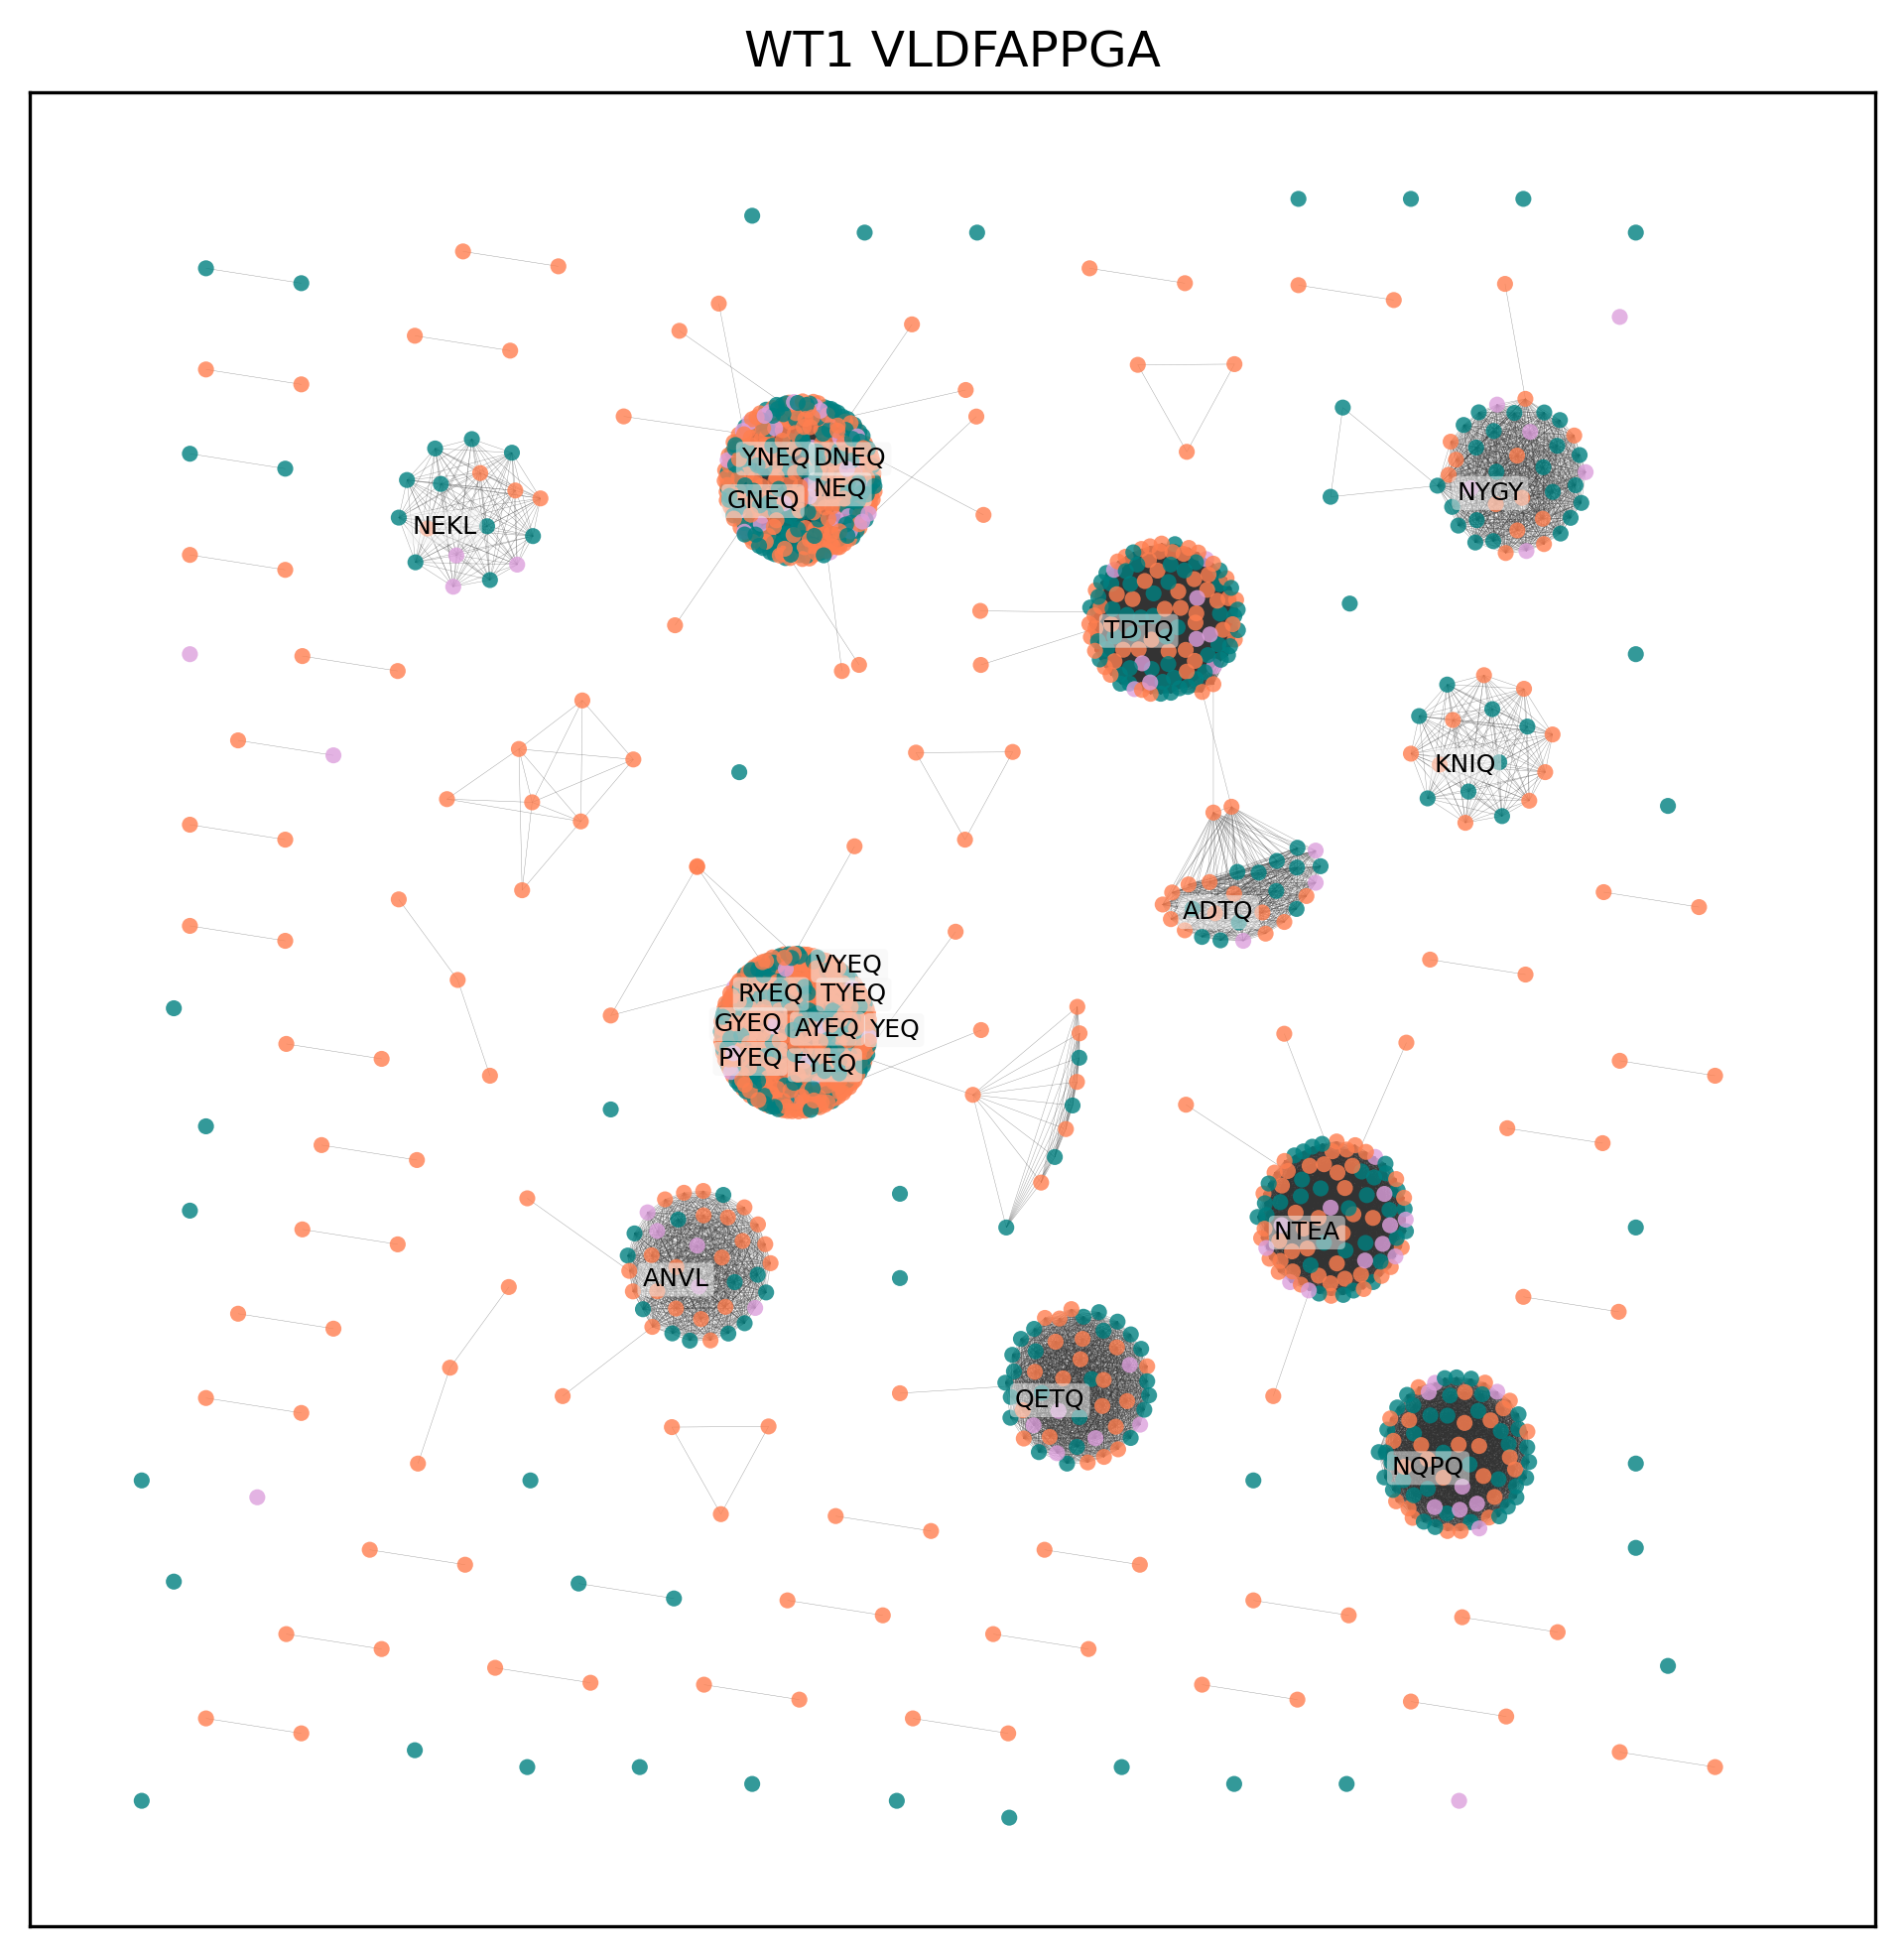

In [5]:
plt.figure(1, figsize=(8, 8),dpi=300)
nx.draw_networkx_nodes(G_vght,pos=pos,node_size=15, node_color=cols_vght,alpha=0.8,linewidths=0)#, vmin=0.0, vmax=1.0)#, with_labels=False)#draw nodes
nx.draw_networkx_edges(G_vght,pos=pos,alpha=0.5,width=0.1,edge_color=(0.2,0.2,0.2))

annotate_patterns(df_nodes_vght,minsize=10,fs=6)

plt.title("WT1 VLDFAPPGA")
plt.savefig("figures/graph_VLD.pdf")
plt.show()

## Visualize GLIPH2 RMF graph

In [6]:
df_RMF_ght = pd.read_csv("data/GLIPH2_RMF_cluster.csv")
df_RMF_ght["id"] = df_RMF_ght["TcRb"] +"_"+ df_RMF_ght["V"] +"_"+ [s.split(":")[1] for s in df_RMF_ght["Sample"]]
G_rght, dol_rght, df_nodes_rght = get_G(df_RMF_ght)

Graph with 362 nodes and 11054 edges
Max degree: 100


In [7]:
cols_rght = get_node_colors(df_nodes_rght,"RMF")

# layout graphs with positions using graphviz neato
pos = nx.nx_agraph.graphviz_layout(G_rght, prog="neato")
pos_ar = np.array(list(pos.values()))

df_nodes_rght["x"]=pos_ar[:,0]
df_nodes_rght["y"]=pos_ar[:,1]

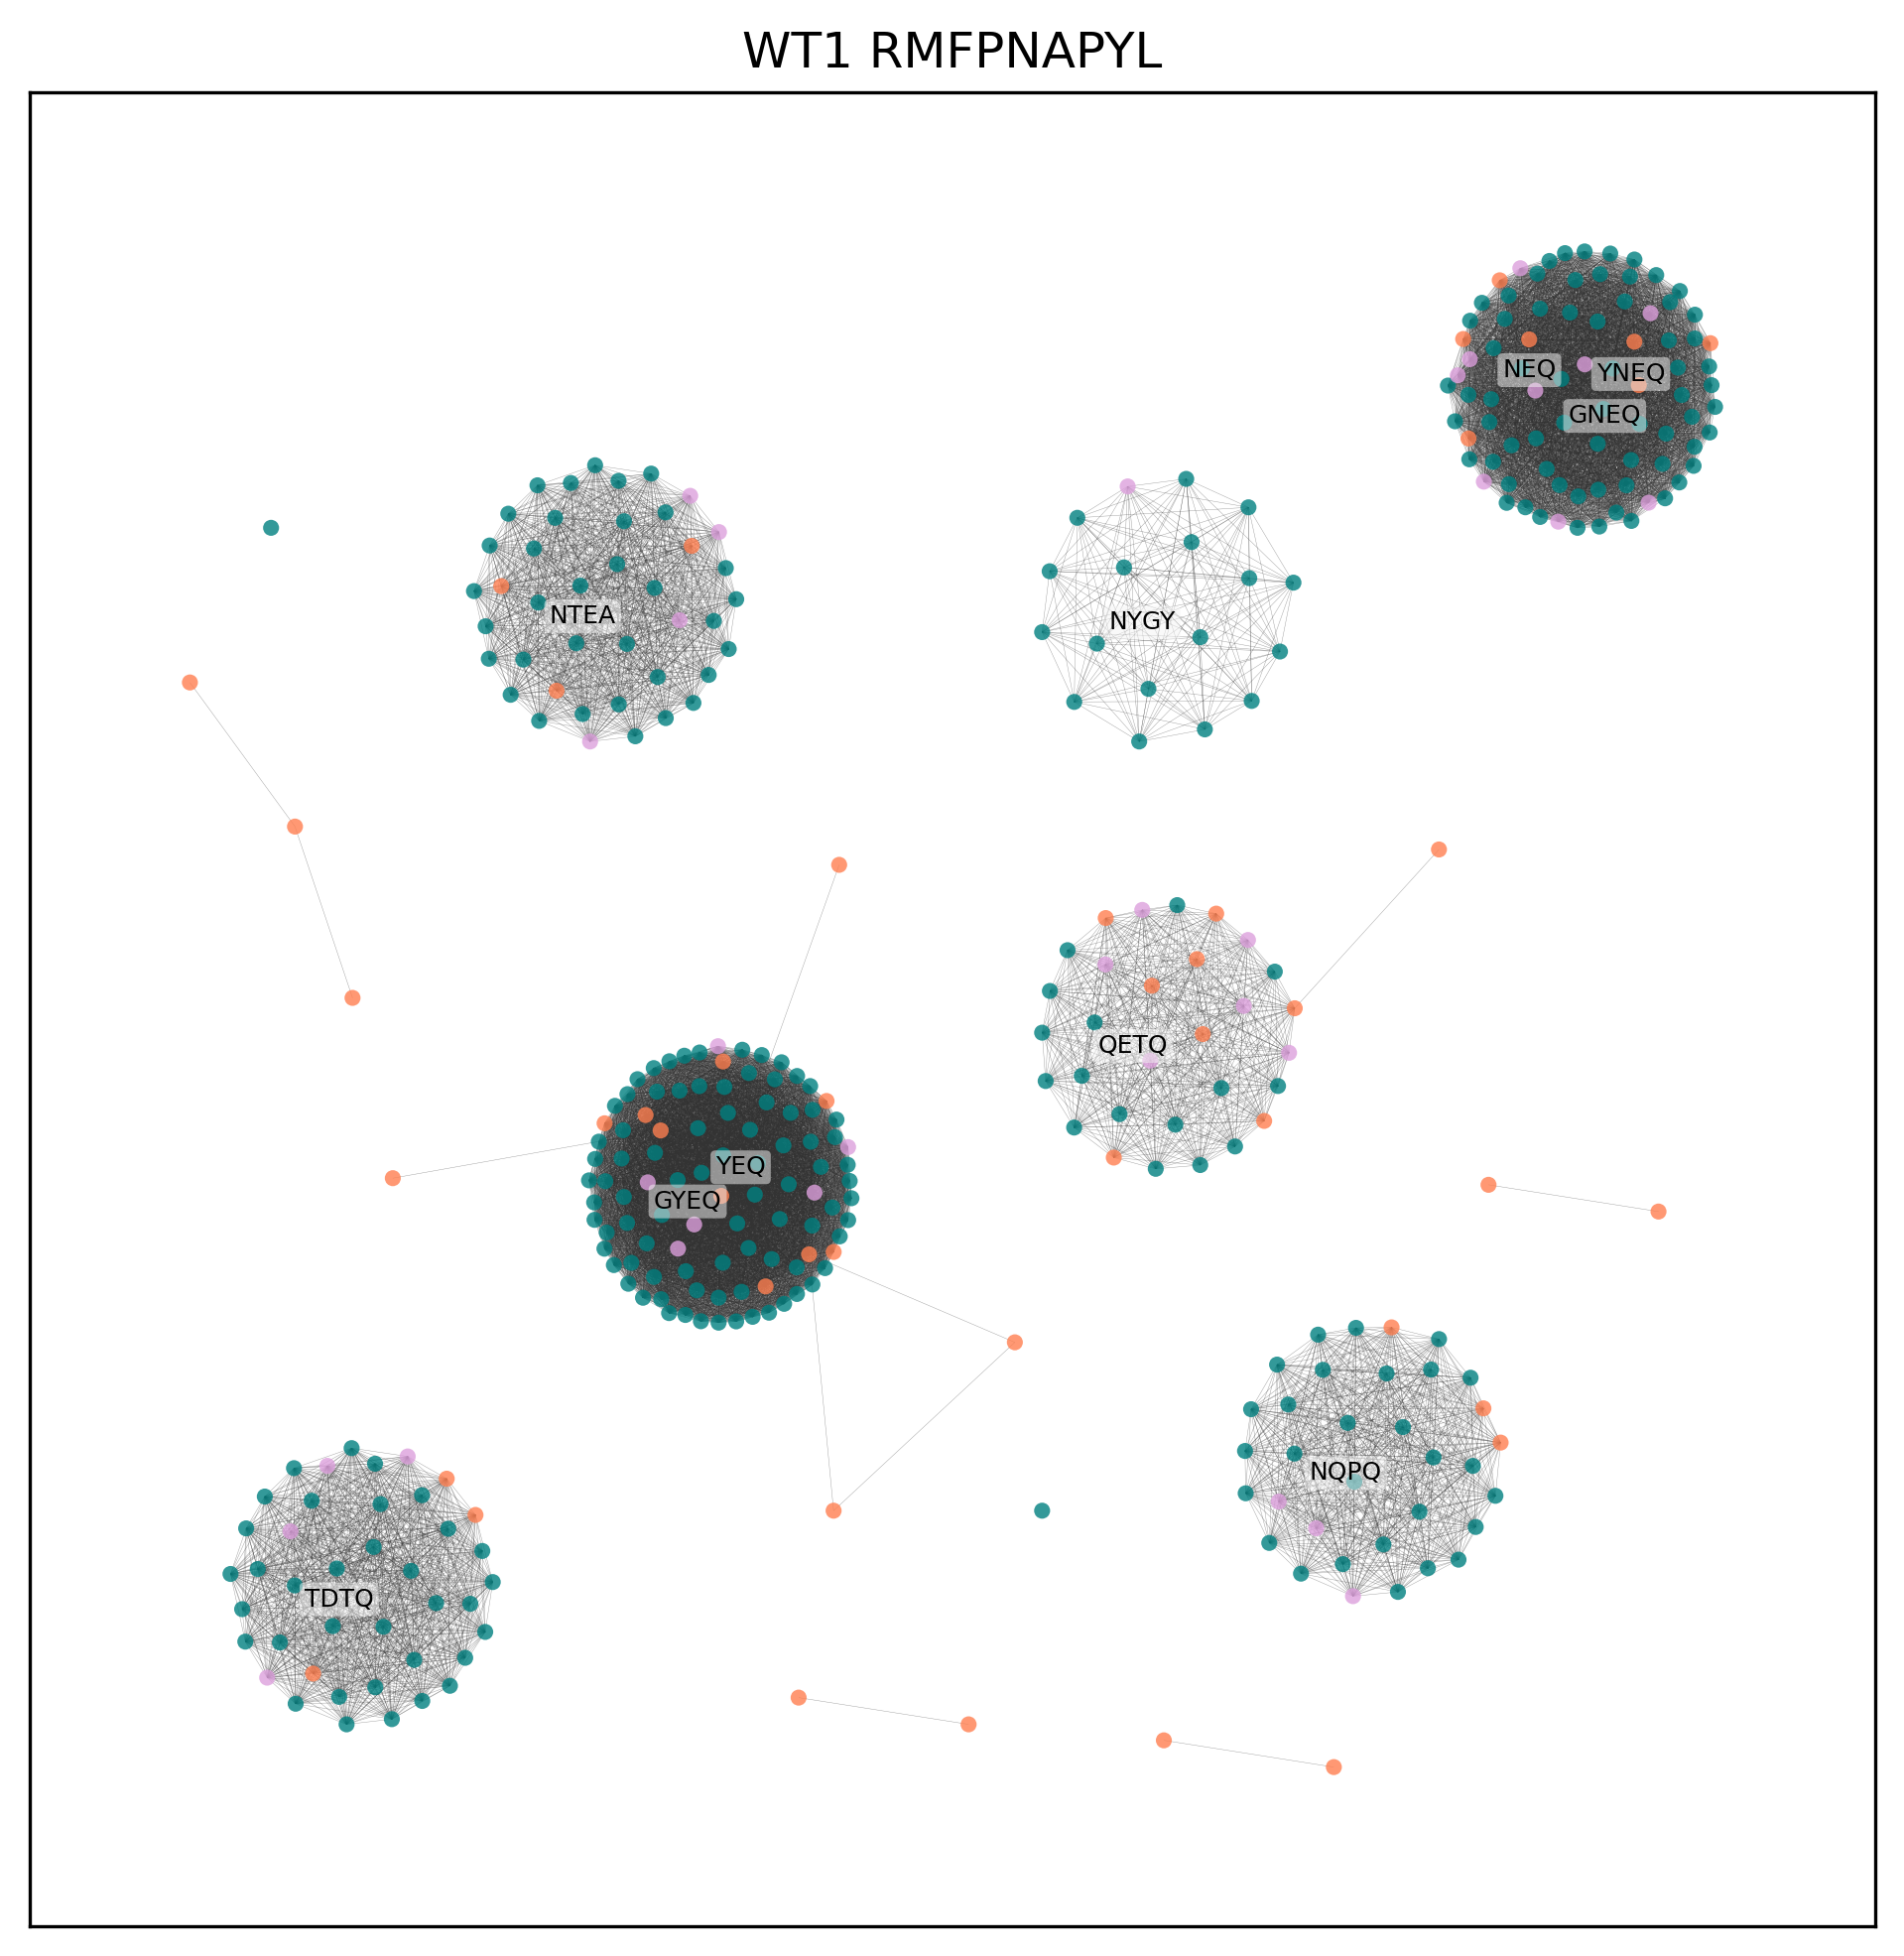

In [8]:
plt.figure(1, figsize=(8, 8),dpi=300)
nx.draw_networkx_nodes(G_rght,pos=pos,node_size=15, node_color=cols_rght,alpha=0.8,linewidths=0)#, vmin=0.0, vmax=1.0)#, with_labels=False)#draw nodes
nx.draw_networkx_edges(G_rght,pos=pos,alpha=0.5,width=0.1,edge_color=(0.2,0.2,0.2))

annotate_patterns(df_nodes_rght,minsize=10,fs=6)

plt.title("WT1 RMFPNAPYL")
plt.savefig("figures/graph_RMF.pdf")
plt.show()